In [8]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os
# import pydicom
from IPython.display import update_display
PATH = "/mnt/d/Datasets/miniMIAS/"
imgPATH = PATH + "all-mias/"
roi_path = PATH + "ROI/"
# malignant_roi_path = PATH + "ROI/malignant/"
# fullimg_benign_path = PATH + "fullimg/benign/"
# fullimg_malignant_path = PATH + "fullimg/malignant/"
image_size=300
output_size=300
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))

In [3]:
def read_pgm(filename, byteorder='>'):                     # '>' indicates big-endian
  """Return image data from a raw PGM file as a np array.

  Format specification: http://netpbm.sourceforge.net/doc/pgm.html

  """

  with open(filename, 'rb') as f:
    buffer = f.read()
  try:
    header, width, height, maxval = re.search(  
    b"(^P5\s(?:\s*#.*[\r\n])*"                             # A pgm image's magic number is the two characters "P5"
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A width, formatted as ASCII characters in decimal
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A height, again in ASCII decimal
    b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()       # The maximum gray value (Maxval), again in ASCII decimal. 
                                                           # Must be less than 65536, and more than zero.
  except AttributeError:
    raise ValueError("Not a raw PGM file: '%s'" % filename)
    
  return np.frombuffer(buffer,
               dtype='u1' if int(maxval) < 256 else byteorder+'u2',
               count=int(width)*int(height),
               offset=len(header)
              ).reshape((int(height),int(width)))
              
def list_find(list, input):
    for i,x in enumerate(list):
        if x[3:6] == input:
            list_index = i
            return int(list_index)

def ROI(img_dir,x,y,r,save_path,file_name,calc):   
  image = read_pgm(img_dir)
  
  if r < 50: r=50
  if 1024-y-r<0:r=1024-y
  elif 1024-y+r>1024:r = y
  if x-r<0:r=x
  elif x+r>1024:r = 1024-x
  image = image[1024-int(y+r):1024-int(y-r),int(x-r):int(x+r)]
  ret,thresh = cv2.threshold(image,1,255,0)
  contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  if contours:
    cnt = contours[-1]
    # plt.imshow(image,cmap='gray')
    x,y,w,h = cv2.boundingRect(cnt)
    # img = cv2.drawContours(image,[cnt],0,(255,255,255),2)
    if w>10 and h>10:
      image = image[y:y+h,x:x+w]
  image = cv2.medianBlur(image,3)
  image = clahe.apply(image)
  image =  cv2.resize(image,(output_size,output_size))
  cv2.imwrite(save_path+file_name+'.png',image)

def ROI_print(img_dir,x,y,r,clahe):   
  image = read_pgm(img_dir)
  image = image[1024-int(y+r):1024-int(y-r),int(x-r):int(x+r)]
  image = cv2.medianBlur(image,3)
  clahe = cv2.createCLAHE(clipLimit=clahe, tileGridSize=(8,8))
  image = clahe.apply(image)
  image =  cv2.resize(image,(output_size,output_size))
  # cv2.imwrite(save_path+file_name+'.png',image)
  return image

def ROI_box(img_dir,x,y,r):   
  image = read_pgm(img_dir)
  # image = image[int(y-r/2):int(y+r/2),int(x-r/2):int(x+r/2)]
  image = cv2.rectangle(image,(int(x-r),1024-int(y+r)),(int(x+r),1024-int(y-r)),(255,255,255),3)
  # image = cv2.medianBlur(image,3)
  # image = clahe.apply(image)
  # image =  cv2.resize(image,(output_size,output_size))
  # cv2.imwrite(save_path+file_name+'.png',image)
  return image

In [4]:
f = open('/mnt/c/Users/user/Desktop/mias-dataset/mias-dataset/MIASinfo.txt', 'r')
line = f.readlines()

In [9]:
# Progress_display = display("0% completed",display_id="Progress_display")
for dirName, subdirList, fileList in os.walk(imgPATH):
  if dirName == imgPATH:
    for i,fname in enumerate(fileList):
        if fname.endswith(".pgm"):
          image_no = fname[3:6]
          indice = list_find(line,image_no)
          if len(line[indice].split(' ')) == 7 and line[indice].split(' ')[-3].isdigit() :
            category = line[indice].split(' ')[3]
            if line[indice].split(' ')[2] == 'CALC': calc = True
            else: calc = False
            if category == 'B':
              ROI(imgPATH+fname,
              int(line[indice].split(' ')[-3]),
              int(line[indice].split(' ')[-2]),
              int(line[indice].split(' ')[-1]),
              roi_path+'benign/',
              'mdb'+str(image_no),
              calc)
              # print(indice)
            elif category == 'M':
              ROI(imgPATH+fname,
              int(line[indice].split(' ')[-3]),
              int(line[indice].split(' ')[-2]),
              int(line[indice].split(' ')[-1]),
              roi_path+'malignant/',
              'mdb'+str(image_no),
              calc)
              # print(indice)
          # update_display(str(int(i/len(fileList)*100))+"% completed",display_id="Progress_display")

print("Extraction completed.")

Extraction completed.


In [87]:
line[218].split(' ')[-3].isdigit()

False

In [38]:
ROI(imgPATH+'mdb001.pgm',
            int(line[0].split(' ')[-3]),
            int(line[0].split(' ')[-2]),
            int(line[0].split(' ')[-1]),
            roi_path+'benign/',
            'mdb001')



In [165]:
indice = list_find(line,'212')
indice

214

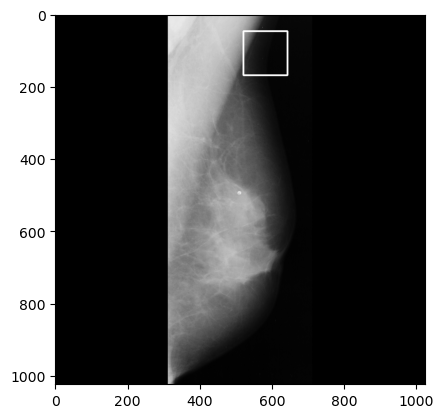

In [167]:
plt.imshow(ROI_box(imgPATH+'mdb214.pgm',
            int(line[216].split(' ')[-3]),
            int(line[216].split(' ')[-2]),
            int(line[216].split(' ')[-1])+50),
            cmap='gray')

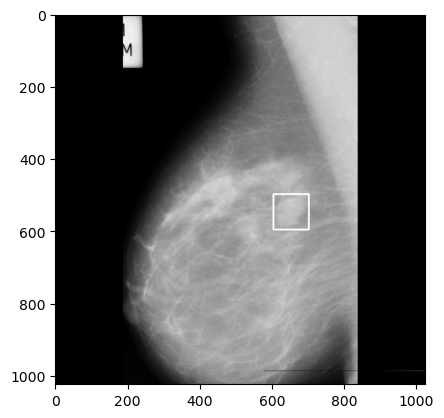

In [89]:
plt.imshow(ROI_box(imgPATH+'mdb019.pgm',
            int(line[19].split(' ')[-3]),
            int(line[19].split(' ')[-2]),
            int(line[19].split(' ')[-1])),
            cmap='gray')

In [54]:
len(contours)

1

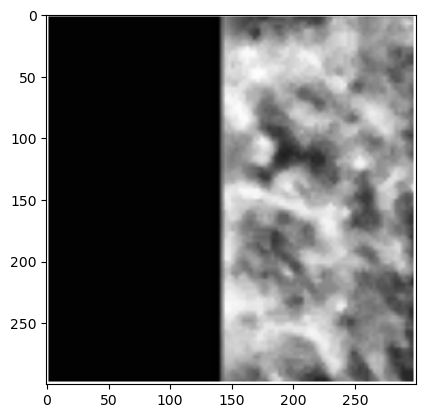

In [139]:
image = ROI_print(imgPATH+'mdb110.pgm',
            int(line[110].split(' ')[-3]),
            int(line[110].split(' ')[-2]),
            int(line[110].split(' ')[-1]),
            20)
ret,thresh = cv2.threshold(image,1,255,0)
contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[-1]
# plt.imshow(image,cmap='gray')
x,y,w,h = cv2.boundingRect(cnt)
img = cv2.drawContours(image,[cnt],0,(255,255,255),2)
image = image[y:y+h,x+1:x+w]
image = clahe.apply(image)
image = cv2.resize(image,(300,300))
plt.imshow(img,cmap='gray')

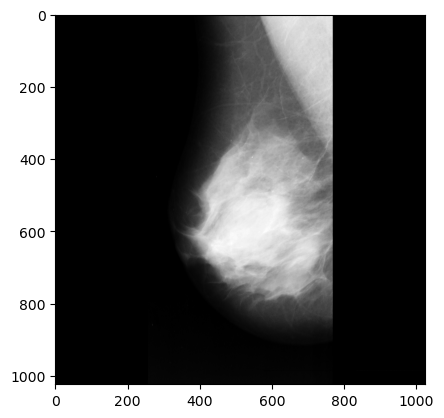

In [43]:
images_tensor = read_pgm(imgPATH+'mdb001.pgm')
plt.imshow(images_tensor, cmap='gray')